<h1 style='text-align: center; font-size: 38px; font-weight: bold; color: #a53860;'> Linear Regression </h1>

<p style='text-align: center; color: #212121;'> This notebook aims to be a place where I can practice Deep Learning with Pythorch in a pratical way. I'll be implementing a Linear Regression model. </p>

<h3 style='color: #da627d; text-align: center;'> Setting Up </h3>

In [221]:
%pip install loguru --quiet

Note: you may need to restart the kernel to use updated packages.


In [222]:

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
from loguru import logger
from tqdm import tqdm
import seaborn as sns
from torch import nn
import pandas as pd
import numpy as np
import torch

%matplotlib inline

train = pd.read_csv('./data/train.csv')
test = pd.read_csv('./data/test.csv')

df = pd.concat([test, train], axis=0, ignore_index=True)

if len(df) != len(train) + len(test):
  logger.error('There is a problem with the dataframe length.')
  raise ValueError('train and test are not the same length')
else:
  logger.success('Dataframe generated successfully with a length of {}.'.format(len(df)))

2023-08-13 16:58:10.177 | SUCCESS  | __main__:<module>:23 - Dataframe generated successfully with a length of 1000.


<h3 style='color: #da627d; text-align: center;'> Quick EDA </h3>

In [223]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       1000 non-null   float64
 1   y       999 non-null    float64
dtypes: float64(2)
memory usage: 15.8 KB


In [224]:
display(pd.DataFrame(df.x.describe()).T)
display(pd.DataFrame(df.y.describe()).T)

,count,mean,std,min,25%,50%,75%,max
x,1000.0,53.771157,113.747929,0.0,25.0,50.0,75.0,3530.157369


,count,mean,std,min,25%,50%,75%,max
y,999.0,50.319804,29.089111,-3.839981,25.18543,49.926397,74.475252,108.871618


In [225]:
df.y = df.y.fillna(df.y.mean())

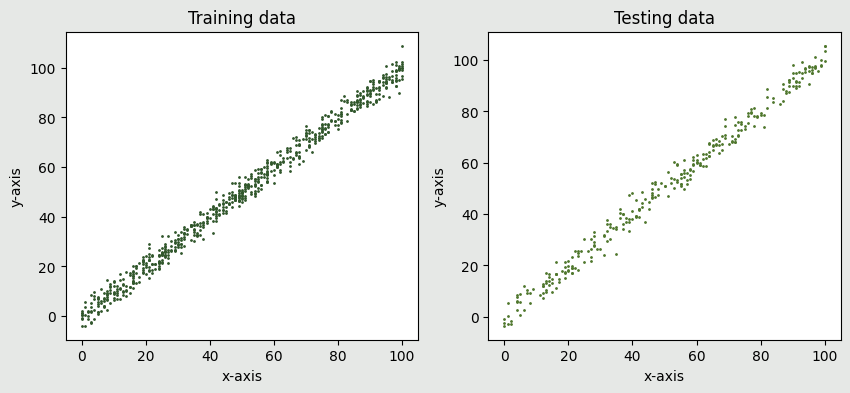

<Figure size 400x350 with 0 Axes>

In [226]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

plt.figure(figsize=(4, 3.5))
fig.patch.set_facecolor('#e6e8e6')

ax1.scatter(train['x'], train['y'], color='#31572c', s=1)
ax1.set_title('Training data')
ax1.set_xlabel('x-axis')
ax1.set_ylabel('y-axis')

ax2.scatter(test['x'], test['y'], color='#4f772d', s=1)
ax2.set_title('Testing data')
ax2.set_xlabel('x-axis')
ax2.set_ylabel('y-axis')

plt.tight_layout()
plt.show()

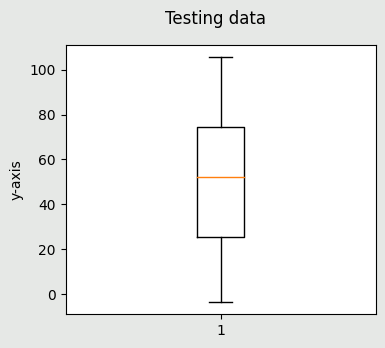

In [227]:
plt.figure(figsize=(4, 3.5))

fig = plt.gcf()
fig.patch.set_facecolor('#e6e8e6')

plt.boxplot(test.y.to_numpy())
plt.suptitle('Testing data')
plt.ylabel('y-axis')

fig.patch.set_facecolor('#e6e8e6')

plt.show()

<h3 style='color: #da627d; text-align: center;'> Preprocessing </h3>

In [290]:
def minmax_transform(array: list[float], range: tuple[int] = (-1, 1)) -> list:
  scaler = MinMaxScaler(feature_range=range)
  scaler.fit([[x] for x in array])

  output = scaler.transform([[x] for x in array]).reshape(-1)
  
  return list(output)

def minmax_inverse_transform(array: list[float], range: tuple[int] = (-1, 1)) -> list:
  scaler = MinMaxScaler(feature_range=range)
  scaler.fit([[x] for x in array])

  output = scaler.inverse_transform([[x] for x in array]).reshape(-1)
  
  return list(output)

df['x_scaled'] = minmax_transform(df.x.tolist(), (0, 1))
df['y_scaled'] = minmax_transform(df.y.tolist(), (0, 1))

df.sample(3)

,x,y,x_scaled,y_scaled
544,58.0,53.830209,0.016430,0.511662
363,51.0,51.901420,0.014447,0.494549
673,10.0,8.938991,0.002833,0.113378


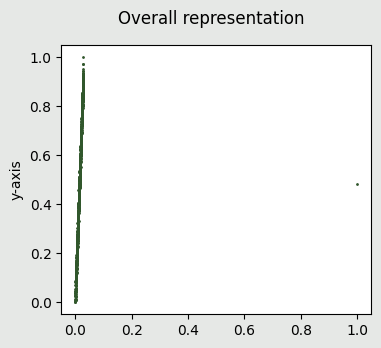

In [291]:
plt.figure(figsize=(4, 3.5))

fig = plt.gcf()
fig.patch.set_facecolor('#e6e8e6')

plt.scatter(df['x_scaled'], df['y_scaled'], color='#31572c', s=1)
plt.suptitle('Overall representation')
plt.ylabel('y-axis')

fig.patch.set_facecolor('#e6e8e6')

plt.show()

In [303]:
X = df.x_scaled.tolist()
y = df.y_scaled.tolist()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

print(f'Length of X_train: {len(X_train)}')
print(f'Length of y_train: {len(y_train)}')
print(f'Length of X_test: {len(X_test)}')
print(f'Length of y_test: {len(y_test)}')

Length of X_train: 670
Length of y_train: 670
Length of X_test: 330
Length of y_test: 330


<h3 style='color: #da627d; text-align: center;'> Modeling </h3>